In [0]:
# 我們會使用到一些內建的資料庫, MAC需要加入以下兩行, 才不會把對方的ssl憑證視為無效
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [4]:
from keras.datasets import mnist
# 回傳值: ((訓練特徵, 訓練目標), (測試特徵, 測試目標))
(x_train, y_train),(x_test, y_test) = mnist.load_data()

In [3]:
x_train.shape

(60000, 28, 28)

In [2]:
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers import BatchNormalization, UpSampling2D, Conv2D
random_dim = 100
generator = Sequential()
# 先讓100隨機亂數可以變成 7 * 7 * 128
# 為何是 7 * 7呢?
# 因為 7 *7 -> (第一次轉置) 14 * 14 -> (第二次轉置) 28 * 28
# 128則是使用類似VGG的概念, 選擇128開始
generator.add(Dense(7 * 7 * 128, input_dim=random_dim, activation='relu'))
# 轉換成三維
generator.add(Reshape((7, 7, 128)))
# 上採樣, 長寬變兩倍
generator.add(UpSampling2D(size=(2, 2)))
# (4, 4)卷積窗的卷積, 之所以做(4, 4)是為了跟discriminator配合, 我們等discriminator再談
generator.add(Conv2D(128, kernel_size=(4, 4), activation='relu', padding='same'))
# 卷積層間我喜歡使用BN來normalize
generator.add(BatchNormalization())
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(64, kernel_size=(4, 4), activation='relu', padding='same'))
generator.add(BatchNormalization())
# 最後讓filter數目回到1, 因為是灰階圖片, 最後輸出 28 * 28 * 1圖片
# 一樣使用tanh(-1 - 1)作為激活
generator.add(Conv2D(1, kernel_size=(4, 4), activation='tanh', padding='same'))
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 128)       262272    
_________________________________________________________________
batch_normalization_3 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 64)        131136    
__________

In [0]:
discriminator = Sequential()
# 步長2卷積
discriminator.add(Conv2D(32, kernel_size=4, 
                         strides=2, 
                         input_shape=(28, 28, 1), 
                         padding="same",
                         activation='relu'))
# 我一樣會在兩層卷積中加入BN
discriminator.add(BatchNormalization())
discriminator.add(Conv2D(64, kernel_size=4, 
                         strides=2, 
                         padding="same",
                         activation='relu'))
discriminator.add(BatchNormalization())
discriminator.add(Conv2D(128, kernel_size=4, 
                         strides=2, 
                         padding="same",
                         activation='relu'))
discriminator.add(BatchNormalization())
# 開始全連接層(MLP)
discriminator.add(Flatten())
discriminator.add(Dense(256, activation='relu'))
discriminator.add(Dropout(0.25))
discriminator.add(Dense(1, activation='sigmoid'))
# 因為鑑賞家是必須單獨訓練的,所以記得compile
discriminator.compile(loss='binary_crossentropy', optimizer="adam")
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 14, 14, 32)        544       
_________________________________________________________________
batch_normalization_3 (Batch (None, 14, 14, 32)        128       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 64)          32832     
_________________________________________________________________
batch_normalization_4 (Batch (None, 7, 7, 64)          256       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 4, 4, 128)         131200    
_________________________________________________________________
batch_normalization_5 (Batch (None, 4, 4, 128)         512       
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
__________

In [6]:
from keras.layers import Input
discriminator.trainable = False
gan_input = Input(shape=(random_dim,))
x = generator(gan_input)
gan_output = discriminator(x)
gan = Model(inputs=gan_input, outputs=gan_output)
gan.compile(loss='binary_crossentropy', optimizer="adam")
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28, 1)         1028673   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 690273    
Total params: 1,718,946
Trainable params: 1,028,289
Non-trainable params: 690,657
_________________________________________________________________


In [9]:
import numpy as np
from keras.utils import np_utils
# reshape讓他從 32 * 32變成 784 * 1的一維陣列
# 讓我們標準化到-1~1區間
x_train_shaped = (x_train - 127.5)/127.5
# 由於我們設定輸入是(28, 28, 1) 所以把(60000, 28, 28) -> (60000, 28, 28, 1)
x_train_shaped = np.expand_dims(x_train_shaped, axis=3)
print('原本維度:', x_train.shape)
print('Expand後維度:', x_train_shaped.shape)

原本維度: (60000, 28, 28)
Expand後維度: (60000, 28, 28, 1)


In [21]:
batch_size = 200
epoch_count = 10
for epoch in range(0, epoch_count):
    for batch_count in range(0, 300):
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        imgs = x_train_shaped[idx]

        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        # 步驟0:讓創作家製造出fake image
        noise = np.random.normal(0, 1, (batch_size, random_dim))
        gen_imgs = generator.predict(noise)

        discriminator.trainable = True
        # 步驟1:讓鑑賞家鑑賞對的image
        d_loss_real = discriminator.train_on_batch(imgs, valid)
        # 步驟2:讓鑑賞家鑑賞錯的image
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = (d_loss_real + d_loss_fake) / 2

        discriminator.trainable = False
        noise = np.random.normal(0, 1, (batch_size, random_dim))
        # 步驟3:訓練創作家的創作能力
        g_loss = gan.train_on_batch(noise, valid)
    if (epoch + 1) % 10 == 0:
        dash = "-" * 15
        print(dash, "epoch", epoch + 1, dash)
        print("Discriminator loss:", d_loss)
        print("Generator loss:", g_loss)


--------------- epoch 10 ---------------
Discriminator loss: 0.030969567596912384
Generator loss: 3.6941195


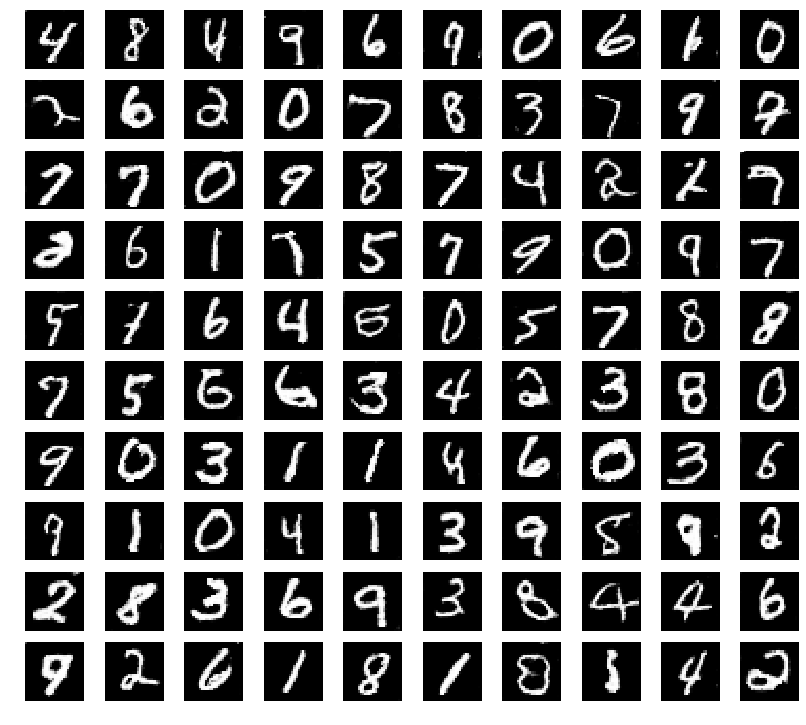

In [25]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
examples = 100
noise = np.random.normal(0, 1, (examples, random_dim))
gen_imgs = generator.predict(noise)

# Rescale images 0 - 1
gen_imgs = 0.5 * gen_imgs + 0.5
gen_imgs = gen_imgs.reshape(examples, 28, 28)
plt.figure(figsize = (14, 14))

w = 10
h = int(examples / w) + 1
for i in range(0, examples):
    plt.subplot(h, w, i + 1)
    plt.axis('off')
    plt.imshow(gen_imgs[i], cmap='gray')
